# Notebook to create dynamic Choropleth map in Notebook and as GIF


* Create interactive graph to explore environmental suitabiltiy over time on world map
* Create GIF files for the two mosquito types and combined

In [5]:
%matplotlib inline
import sys
sys.path.append('project_modules')

# from libraries for interactive visualization on map
from ipywidgets import interact, FloatSlider, IntSlider,RadioButtons, Dropdown
from IPython.display import clear_output, display
from itertools import imap

# Import libraries for data handling
import pandas as pd
import numpy as np
import geopandas as gp

# # Import libraries for visualization
from matplotlib.collections import PatchCollection
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style('white')
sns.set_palette('deep')
plt.rcParams['figure.figsize'] = 20, 8

In [7]:
gdf_map_elements = gp.read_file('preprocessing_results/geojson/gdf_map_elements.geojson')

import matplotlib_polygon_lst
dict_mapindex_mpl_polygon = matplotlib_polygon_lst.add(gdf_map_elements)

In [8]:
multiindex_plot_suitability = pd.read_csv('preprocessing_results/csv_files/Env_suitability_monthly.csv',
                                          index_col=[0, 1]) # Account for multindex 
multiindex_plot_suitability.index.names = [None, None] # Delete index names created from reading/saving to csv
multiindex_plot_suitability.rename(columns={k:int(k) for k in multiindex_plot_suitability.columns.tolist()},
                                   inplace=True)# Convert column names from string to integer

In [9]:
multiindex_plot_suitability.head()

1         2         3         4         5         6   \
Aegypti 0  0.003574  0.004818  0.005626  0.005685  0.013484  0.016749   
        1  0.005973  0.008236  0.012229  0.011797  0.047884  0.048798   
        2  0.003298  0.005365  0.006634  0.015468  0.042516  0.044633   
        3  0.000756  0.000721  0.000711  0.000770  0.000596  0.000714   
        4  0.002693  0.002790  0.002858  0.002983  0.002460  0.001520   

                 7         8         9         10        11        12  
Aegypti 0  0.020543  0.022927  0.016433  0.014458  0.003544  0.003349  
        1  0.082856  0.090128  0.062663  0.056822  0.006036  0.005556  
        2  0.137644  0.125031  0.065523  0.034395  0.010564  0.002492  
        3  0.000658  0.001884  0.001920  0.001142  0.001777  0.000780  
        4  0.002314  0.002365  0.007707  0.002683  0.002441  0.002547

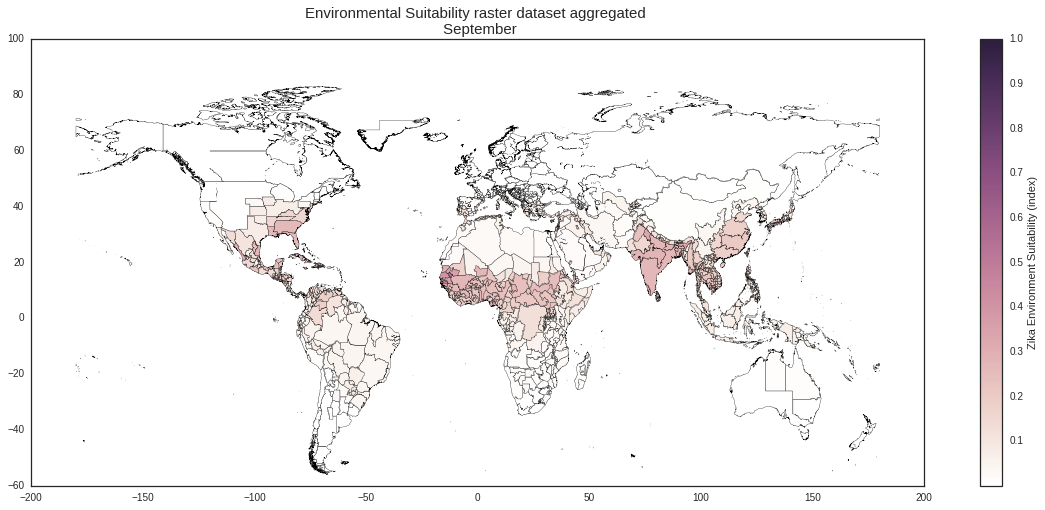

In [10]:
month_lst = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
              'August', 'September', 'October', 'November', 'December']

species=['Aegypti', 'Albopictus', 'Both']

drop_1 = Dropdown(description = 'Scenario', 
                       options=species,value='Aegypti')

slider_2 = IntSlider(description = 'Time Select',min=1, max=12, value=1)


@interact(sv2 = slider_2, spec=drop_1)
def update_map(sv2, spec):
#     fig, ax = plt.subplots() #figsize=(12, 8)
    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    fig, ax = plt.subplots()
    for c_l ,patches in dict_mapindex_mpl_polygon.items():
        color = multiindex_plot_suitability.loc[spec].loc[c_l, sv2]
        p = PatchCollection(patches,color=cmap(color),lw=.3,edgecolor='k')
        ax.add_collection(p)
    ax.autoscale_view()

    p.set(array=multiindex_plot_suitability.loc[spec][sv2].values, cmap=cmap)
    fig.colorbar(p, label="Zika Environment Suitability (index)")

    ax.set_title('Environmental Suitability raster dataset aggregated \n {}'.format(month_lst[sv2-1]), fontsize=15)
    ax.set_ylim([-60, 100])
    fig = mpl.pyplot.gcf()
    plt.show()

#### Generate GIF Files of different vector types over time

In [11]:
### Function to update map over time and select mosquito specie

def update_map(sv2, spec):
    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    fig, ax = plt.subplots()
    for c_l ,patches in dict_mapindex_mpl_polygon.items():
        color = multiindex_plot_suitability.loc[spec].loc[c_l, sv2]
        p = PatchCollection(patches,color=cmap(color),lw=.3,edgecolor='k')
        ax.add_collection(p)
    ax.autoscale_view()

    p.set(array=multiindex_plot_suitability.loc[spec][sv2].values, cmap=cmap)
    fig.colorbar(p, label="Zika Environment Suitability (index)")

    ax.set_title('Environmental Suitability raster dataset aggregated \n {}'.format(month_lst[sv2-1]), fontsize=15)
    ax.set_ylim([-60, 100])
    fig = mpl.pyplot.gcf()


In [12]:
### Script to generate the images and save them in desingated folder

import os 
for Scenario in species:
    #Create new directory if it does not excist already
    path = 'figs/img_gif_{}'.format(Scenario)
    try: 
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise
    #Deleting all files in a directory with Python        
    try:        
        filelist = [ f for f in os.listdir(".") if f.endswith(".png") ]
        for f in filelist:
            os.remove(f)
    except:
        pass
    #Update the plot over time and save image in folder    
    for timestep in range(1, 13, 1): 
        update_map(sv2 = timestep, spec= Scenario) 
        plt.savefig(path+'/{}.png'.format(timestep))   # save the figure to file
        plt.close()

In [13]:
### Script to compile images to GIF

import imageio

kargs = { 'duration': 1.5 }

for Scenario in species:

# Scenario = 'second_worst'
# Sc
    file_path =  r'figs/img_gif_{}'.format(Scenario)
    file_names = sorted((os.path.join(file_path, fn) 
                         for fn in os.listdir(file_path) if fn.endswith('.png')))

    file_names.sort(key=lambda f: int(filter(str.isdigit, f)))

    images = []
    for filename in file_names:
        images.append(imageio.imread(filename))
    imageio.mimsave(r'figs/Animation_{}_v2.gif'.format(Scenario), images, **kargs)
